In [64]:
!pip install tf-keras transformers tensorflow statsmodels seaborn scikit-learn > Null

In [65]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Stocks data

In [75]:
import pandas as pd

product_name = 'ICLN'
prices_df = pd.read_csv(f'datasets/{product_name}.csv')

print(f'Number of rows: {prices_df.shape[0]}')
print(f'Missing values: {prices_df["Close"].isnull().sum()}')


# Convert the 'Date' column in prices_df to datetime
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date


# Set 'Date' as the index
prices_df.set_index('Date', inplace=True)

# Reindex to business days to fill missing dates
business_days = pd.bdate_range(start=prices_df.index.min(), end=prices_df.index.max())
prices_df = prices_df.reindex(business_days)

# Fill missing values (e.g., forward fill)
prices_df = prices_df.ffill()

print(f'first date: {prices_df.index.min()}')
print(f'last date: {prices_df.index.max()}')

prices_df.tail()

Number of rows: 4035
Missing values: 0
first date: 2008-06-25 00:00:00
last date: 2024-07-08 00:00:00


,Open,High,Low,Close,Adj Close,Volume
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0


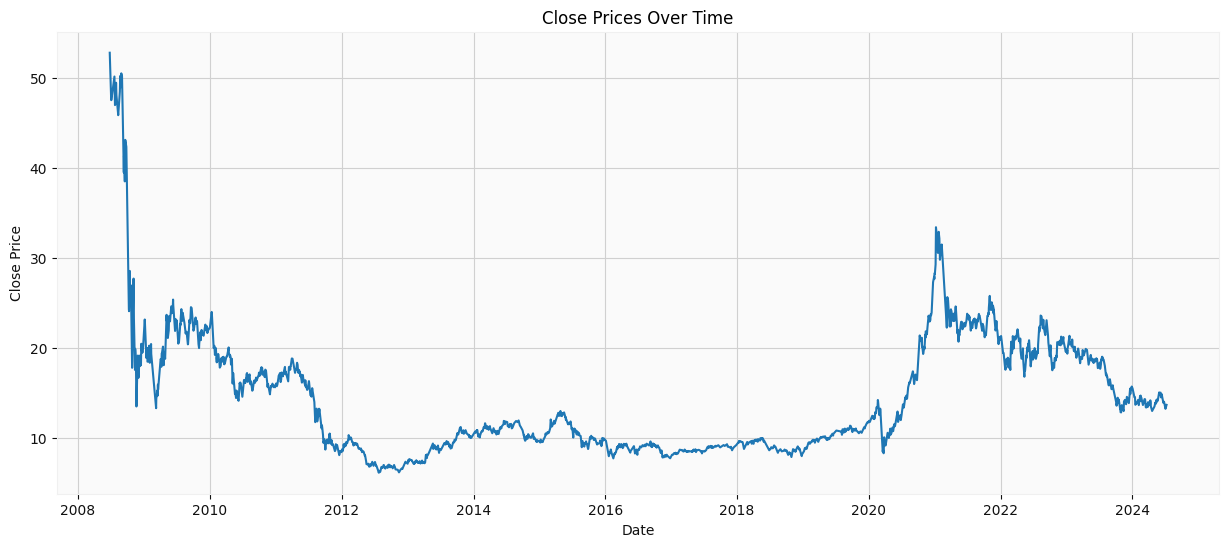

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the 'Close' column
plt.figure(figsize=(15, 6))
sns.lineplot(data=prices_df, x=prices_df.index, y='Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.show()


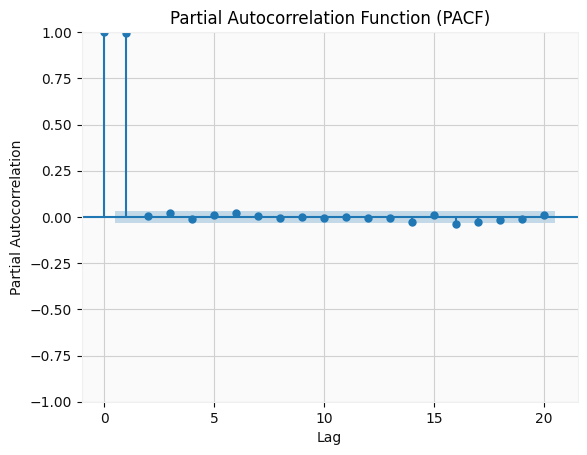

PACF Scores:
Lag 0: 1.0
Lag 1: 0.9948274244337907
Lag 2: 0.0076852692789298955
Lag 3: 0.020783250452186035
Lag 4: -0.011007247103308996
Lag 5: 0.013196605613297007
Lag 6: 0.020924650141199364
Lag 7: 0.008025842826467846
Lag 8: -0.0037719900729677987
Lag 9: 0.00209127359799035
Lag 10: -0.007647865357595332
Lag 11: 0.0019161523672270014
Lag 12: -0.007190719388653563
Lag 13: -0.005983146289337068
Lag 14: -0.026939997351142025
Lag 15: 0.010138808846247611
Lag 16: -0.03949588830705335
Lag 17: -0.03024087226781524
Lag 18: -0.01856871882317833
Lag 19: -0.012610656596675084
Lag 20: 0.010755463044629342


In [77]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Calculate PACF
pacf_scores = pacf(prices_df['Close'], nlags=20)

# Plot PACF
plot_pacf(prices_df['Close'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Print PACF scores
print("PACF Scores:")
for lag, score in enumerate(pacf_scores):
    print(f"Lag {lag}: {score}")

We can see that Lag 1 prices are the most correlated with the current price

## Additional Features

Technical features

In [78]:
#Lagged Features
# Create lag columns for 'Close', 'Open', 'High', 'Low'
prices_df['Close_Lag1'] = prices_df['Close'].shift(1)
prices_df['Open_Lag1'] = prices_df['Open'].shift(1)
prices_df['High_Lag1'] = prices_df['High'].shift(1)
prices_df['Low_Lag1'] = prices_df['Low'].shift(1)

# Technical Indicators
# Moving Averages
prices_df['SMA_5'] = prices_df['Close'].rolling(window=5).mean()
prices_df['SMA_10'] = prices_df['Close'].rolling(window=10).mean()
prices_df['SMA_20'] = prices_df['Close'].rolling(window=20).mean()
prices_df['SMA_100'] = prices_df['Close'].rolling(window=100).mean()

# Relative Strength Index (RSI)
def compute_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
prices_df['RSI_14'] = compute_rsi(prices_df['Close'], 14)

# Bollinger Bands
prices_df['BB_middle'] = prices_df['Close'].rolling(window=20).mean()
prices_df['BB_std'] = prices_df['Close'].rolling(window=20).std()
prices_df['BB_upper'] = prices_df['BB_middle'] + (prices_df['BB_std'] * 2)
prices_df['BB_lower'] = prices_df['BB_middle'] - (prices_df['BB_std'] * 2)

# Momentum
prices_df['MOM_10'] = prices_df['Close'].diff(10)


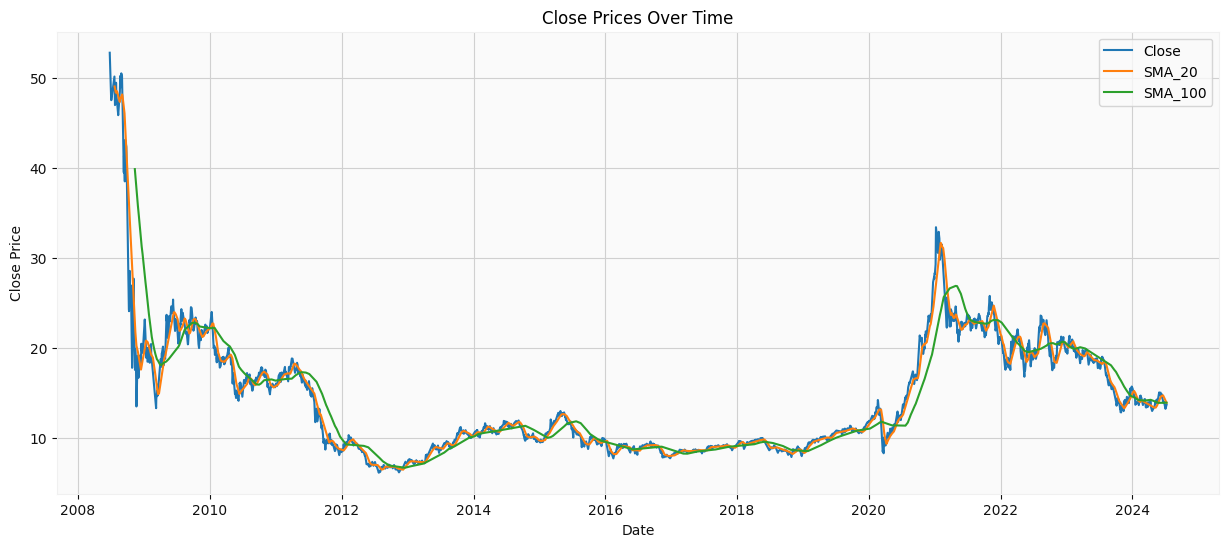

In [79]:
from cProfile import label
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the 'Close' column
plt.figure(figsize=(15, 6))
sns.lineplot(data=prices_df, x=prices_df.index, y='Close', label='Close')
sns.lineplot(data=prices_df, x=prices_df.index, y='SMA_20', label='SMA_20')
sns.lineplot(data=prices_df, x=prices_df.index, y='SMA_100', label='SMA_100')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.legend()
plt.show()


Constituents features

In [80]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/Constituents'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_constituent'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,...,BB_lower,MOM_10,close_600900_constituent,close_ENPH_constituent,close_ORSTED_constituent,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,...,13.056839,-0.88,29.480000,95.769997,371.200012,10.7,88.970001,10912.799805,216.729996,160.250000
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,...,13.038680,-0.55,29.299999,99.169998,383.600006,10.7,88.709999,11056.799805,231.110001,162.800003
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,13.34,...,13.023517,-0.36,29.389999,NaN,389.500000,10.7,NaN,11066.299805,NaN,163.199997
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,...,12.990026,-0.30,29.389999,97.139999,399.500000,10.6,89.269997,11023.500000,222.119995,163.899994
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,...,13.003496,-0.35,29.920000,102.809998,387.700012,10.5,88.419998,11022.099609,227.119995,162.550003


Other ETFs

In [81]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/other ETFs'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_etf'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,...,close_ENPH_constituent,close_ORSTED_constituent,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent,close_XLU_etf,close_XLK_etf,close_XLI_etf
2024-07-01,13.40,13.49,13.29,13.31,13.31,3762900.0,13.32,13.66,13.71,13.28,...,97.260002,376.000000,11.2,88.809998,11057.000000,222.710007,162.100006,67.669998,227.940002,120.559998
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,...,95.769997,371.200012,10.7,88.970001,10912.799805,216.729996,160.250000,68.019997,229.080002,121.220001
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,...,99.169998,383.600006,10.7,88.709999,11056.799805,231.110001,162.800003,68.430000,232.169998,121.660004
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,...,97.139999,399.500000,10.6,89.269997,11023.500000,222.119995,163.899994,68.550003,232.880005,121.220001
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,...,102.809998,387.700012,10.5,88.419998,11022.099609,227.119995,162.550003,68.620003,234.470001,121.370003


In [82]:
prices_df.to_csv('ICLN_data.csv', index=True)

## Articles


In [27]:
articles_name = 'green_energy_articles'
articles_df = pd.read_csv(f'datasets/scrapped_news/{articles_name}.csv')
articles_df['Time'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST')
# Convert the 'Time' column in articles_df to datetime
articles_df['Date'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST').dt.date


print(f'Number of articles: {articles_df.shape[0]}')
articles_df.head()

Number of articles: 38


,Title,Link,Description,Time,Date
0,"NexGen Energia plans to invest Rs 15,000 cr ov...",https://economictimes.indiatimes.com/industry/...,"NexGen Energia plans a Rs 15,000 crore investm...",2024-07-07 13:52:00,2024-07-07
1,JSW Energy plans ₹1.15 L cr capex to diversify...,https://economictimes.indiatimes.com/industry/...,JSW Energy announces a strategic shift towards...,2024-07-06 00:35:00,2024-07-06
2,Interest subvention likely to push energy effi...,https://economictimes.indiatimes.com/industry/...,The power ministry has begun discussions on of...,2024-07-05 23:45:00,2024-07-05
3,MNRE issues incentive guidelines for green hyd...,https://economictimes.indiatimes.com/industry/...,Solar Energy Corporation of India (SECI) is th...,2024-07-05 17:29:00,2024-07-05
4,Norms issued for funding of testing facilities...,https://economictimes.indiatimes.com/industry/...,The Ministry of New and Renewable Energy has r...,2024-07-05 00:41:00,2024-07-05


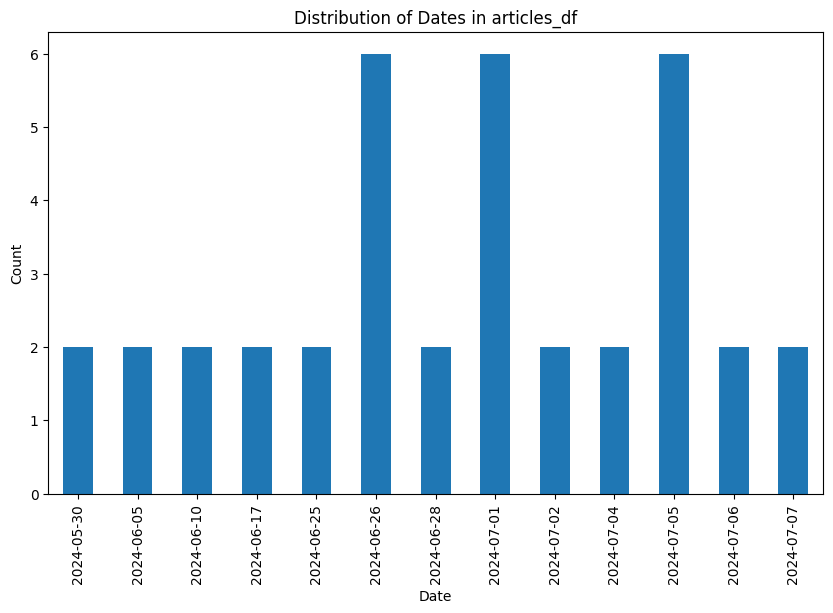

In [28]:
import matplotlib.pyplot as plt

# Count the occurrences of each date
date_counts = articles_df['Date'].value_counts()

# Sort the date_counts index to make sure the dates are in order
date_counts = date_counts.sort_index()

# Plot the distribution of dates
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Dates in articles_df')
plt.show()

In [29]:
# Reset the index to ensure 'Date' is a column
prices_df.reset_index(inplace=True)
prices_df.rename(columns={'index': 'Date'}, inplace=True)
# Convert the 'Date' column in prices_df to datetime and extract only the date part
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
prices_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,...,close_ENPH_constituent,close_ORSTED_constituent,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent,close_XLU_etf,close_XLK_etf,close_XLI_etf
4030,2024-07-01,13.40,13.49,13.29,13.31,13.31,3762900.0,13.32,13.66,13.71,...,97.260002,376.000000,11.2,88.809998,11057.000000,222.710007,162.100006,67.669998,227.940002,120.559998
4031,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,...,95.769997,371.200012,10.7,88.970001,10912.799805,216.729996,160.250000,68.019997,229.080002,121.220001
4032,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,...,99.169998,383.600006,10.7,88.709999,11056.799805,231.110001,162.800003,68.430000,232.169998,121.660004
4033,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,...,97.139999,399.500000,10.6,89.269997,11023.500000,222.119995,163.899994,68.550003,232.880005,121.220001
4034,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,...,102.809998,387.700012,10.5,88.419998,11022.099609,227.119995,162.550003,68.620003,234.470001,121.370003


In [30]:
# Merge articles with prices_df on date
merged_df = pd.merge(prices_df, articles_df, on='Date', how='left')

# Aggregate articles by date
aggregated_articles = merged_df.groupby('Date').agg({
    'Title': lambda x: ' '.join(x.dropna()),
    'Description': lambda x: ' '.join(x.dropna())
}).reset_index()

# Merge aggregated articles back with prices_df
final_df = pd.merge(prices_df, aggregated_articles, on='Date', how='left')
final_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,...,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent,close_XLU_etf,close_XLK_etf,close_XLI_etf,Title,Description
4030,2024-07-01,13.40,13.49,13.29,13.31,13.31,3762900.0,13.32,13.66,13.71,...,11.2,88.809998,11057.000000,222.710007,162.100006,67.669998,227.940002,120.559998,"AM Green, SJVN arm ink MoU for supply and sour...",AM Green's partnership with SJVN Green Energy ...
4031,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,...,10.7,88.970001,10912.799805,216.729996,160.250000,68.019997,229.080002,121.220001,World’s most volatile big stock is rocking Ind...,Indonesia's stock market faces turmoil as PT B...
4032,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,...,10.7,88.709999,11056.799805,231.110001,162.800003,68.430000,232.169998,121.660004,,
4033,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,...,10.6,89.269997,11023.500000,222.119995,163.899994,68.550003,232.880005,121.220001,Interest subvention likely to push energy effi...,The power ministry has begun discussions on of...
4034,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,...,10.5,88.419998,11022.099609,227.119995,162.550003,68.620003,234.470001,121.370003,,


Reddit Scraper


In [3]:
import praw
import pandas as pd

CLIENT_ID = 'SBqeY_vwoICNj_JebXVe6w'
CLIENT_SECRET = 'mVBreyVTFOdBAK0VKAFHtggcGDRR5w'
USER_AGENT = 'Michael_bot'

reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=USER_AGENT)

subreddit = reddit.subreddit('ideas')
top_posts = subreddit.top(limit=200)


def count_words(text):
    return len(text.split())


ideas = []
for post in top_posts:
    title = post.title
    text = post.selftext
    total_words = count_words(title) + count_words(text)

    if total_words >= 50:
        idea = {
            'title': title,
            'upvotes': post.score,
            'url': post.url,
            'text': text,
            'total_words': total_words
        }
        ideas.append(idea)

# Print the filtered ideas
for idx, idea in enumerate(ideas, start=1):
    if idx > 0:
        print(f"{idx}. {idea['title']}\nURL: {idea['url']}\nText: {idea['text']}\n")

1. Should prisons be rewarded for criminals who don't re-offend, and fined for those who do?
URL: https://www.reddit.com/r/ideas/comments/1ntd1d/should_prisons_be_rewarded_for_criminals_who_dont/
Text: Right now, prisons are incentivized *not* to rehabilitate prisoners, because it would result in less revenue to the prison. But society wins when a criminal is successfully rehabilitated. I think prisons should share society's gain, like a sort of profit sharing, to fix the conflict of interest. Because this would be would be revenue-neutral (total rewards equal total fines), it wouldn't cost taxpayers anything.

What would be the disadvantages of this strategy?

2. Infinite opps
URL: https://www.reddit.com/r/ideas/comments/11p7ra2/infinite_opps/
Text: Opps getting so rare nowadays that mfs be recruiting them but there is a simple solution that creates an infiniite amount of them. SO yall remember when scientists cloned a sheep or smth anyway why dont we just apply that on humans. Now i 

In [44]:
prices_df.set_index('Date', inplace=True)


,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,...,close_ENPH_constituent,close_ORSTED_constituent,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent,close_XLU_etf,close_XLK_etf,close_XLI_etf
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-25,52.250000,52.980000,52.250000,52.770000,37.889431,2000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.099998,12446.099609,290.130005,132.199997,41.299999,23.700001,35.279999
2008-06-26,60.000000,60.000000,50.990002,51.060001,36.661633,9800.0,52.770000,52.250000,52.980000,52.250000,...,NaN,NaN,NaN,39.169998,12077.700195,273.269989,128.399994,40.070000,23.250000,34.700001
2008-06-27,50.790001,50.790001,50.090000,50.160000,36.015419,7700.0,51.060001,60.000000,60.000000,50.990002,...,NaN,NaN,NaN,38.419998,12089.799805,266.250000,126.199997,39.730000,22.940001,33.700001
2008-06-30,50.770000,50.959999,50.250000,50.250000,36.080048,17100.0,50.160000,50.790001,50.790001,50.090000,...,NaN,NaN,NaN,39.090000,12046.200195,272.820007,124.000000,40.700001,22.910000,34.009998
2008-07-01,50.000000,50.000000,48.060001,48.799999,35.038921,14900.0,50.250000,50.770000,50.959999,50.250000,...,NaN,NaN,NaN,38.759998,11770.900391,270.679993,123.599998,40.910000,22.750000,33.990002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,13.400000,13.490000,13.290000,13.310000,13.310000,3762900.0,13.320000,13.660000,13.710000,13.280000,...,97.260002,376.000000,11.2,88.809998,11057.000000,222.710007,162.100006,67.669998,227.940002,120.559998
2024-07-02,13.260000,13.420000,13.180000,13.260000,13.260000,2154900.0,13.310000,13.400000,13.490000,13.290000,...,95.769997,371.200012,10.7,88.970001,10912.799805,216.729996,160.250000,68.019997,229.080002,121.220001
2024-07-03,13.360000,13.640000,13.340000,13.590000,13.590000,4990500.0,13.260000,13.260000,13.420000,13.180000,...,99.169998,383.600006,10.7,88.709999,11056.799805,231.110001,162.800003,68.430000,232.169998,121.660004


In [49]:
data

,Open,High,Low,Close,Volume,ROC
Date,,,,,,
2023-08-01,7102,7945,7030,7383,365564,NaN
2023-08-02,7435,7983,7036,7322,458896,-0.826222
2023-08-03,7348,7769,6942,7600,231373,3.796777
2023-08-04,7270,7850,6970,7493,215294,-1.407895
2023-08-05,7106,7803,6828,7479,224019,-0.186841
...,...,...,...,...,...,...
2023-11-04,7401,7595,7215,7572,203481,4.513458
2023-11-05,7217,7887,7046,7717,474710,1.914950
2023-11-06,7043,7721,7123,7298,125945,-5.429571


/opt/miniconda3/envs/fintech_env/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


(<Figure size 1725x1150 with 6 Axes>,
 [<Axes: ylabel='Price'>,
  <Axes: >,
  <Axes: ylabel='Volume\n  $10^{6}$'>,
  <Axes: >,
  <Axes: ylabel='ROC'>,
  <Axes: >])

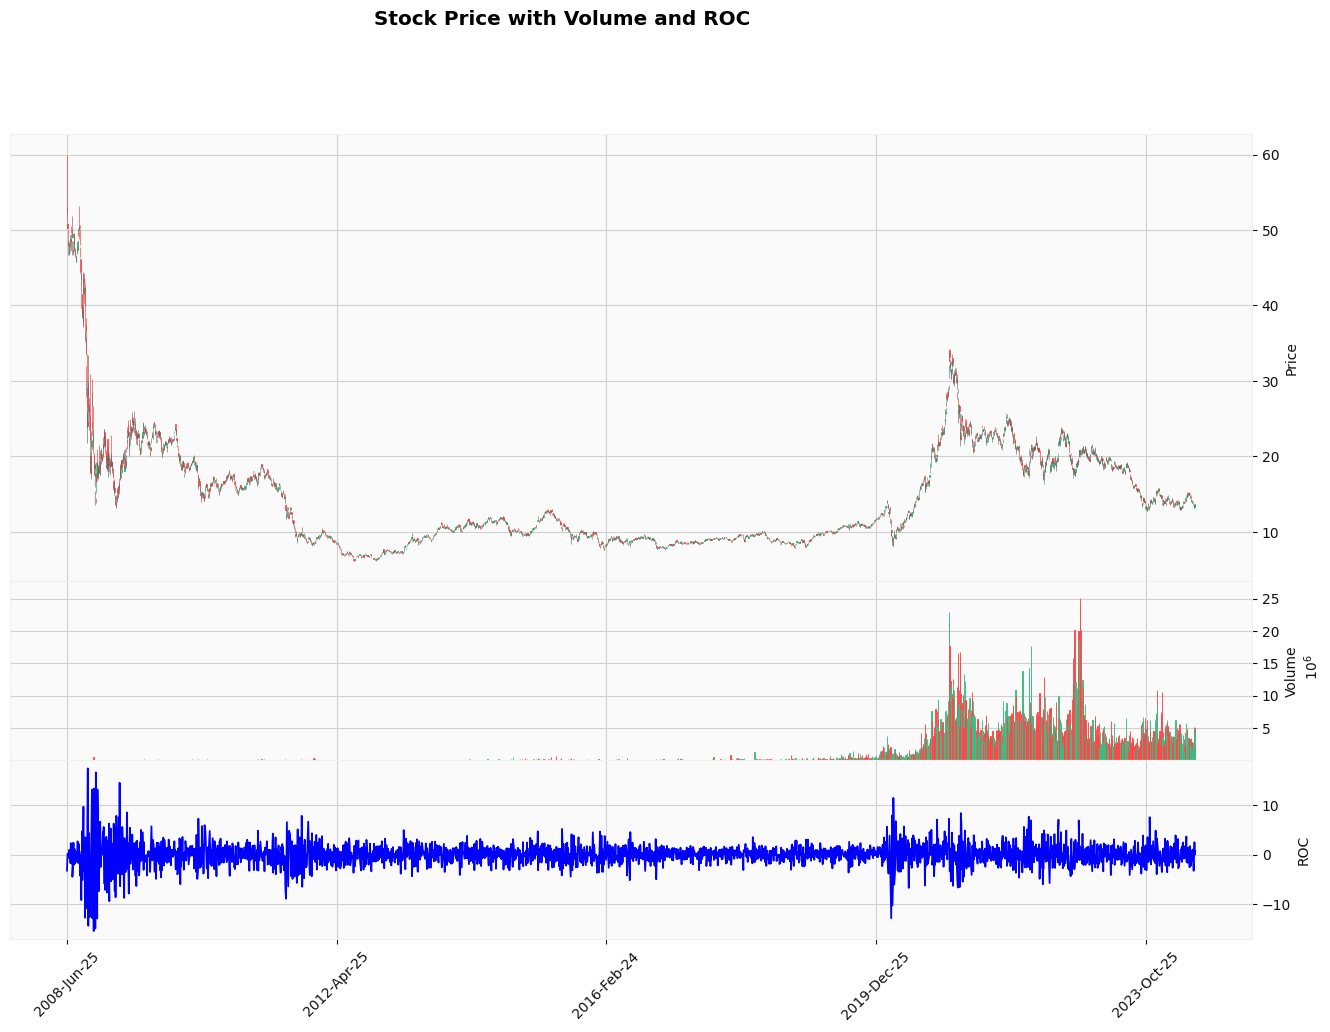

In [55]:
import pandas as pd
import numpy as np
import mplfinance as mpf

# prices_df.set_index('Date', inplace=True)

# # Step 2: Calculate the Rate of Change (ROC)
prices_df['ROC'] = ((prices_df['Close'] - prices_df['Close'].shift(1)) / prices_df['Close'].shift(1)) * 100

# Step 3: Plot the candlestick chart, volume, and ROC
mpf.plot(prices_df,
         type='candle',
         style='yahoo',
         volume=True,
         addplot=mpf.make_addplot(prices_df['ROC'], panel=2, color='blue', ylabel='ROC'),
         title='Stock Price with Volume and ROC',
         ylabel='Price',
         ylabel_lower='Volume',
         figratio=(12, 8), 
         figscale=2,
         returnfig=True)
